In [557]:
import pandas as pd
import numpy as np

In [558]:
train_df = pd.read_excel('train.xlsx')
train_df = train_df.sort_values(by='dt')
train_df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [559]:
train_df.head(13)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [560]:
train_df.isna().sum()

,0
dt,0
Цена на арматуру,0


In [561]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [562]:
train_df.set_index('dt', inplace=True)

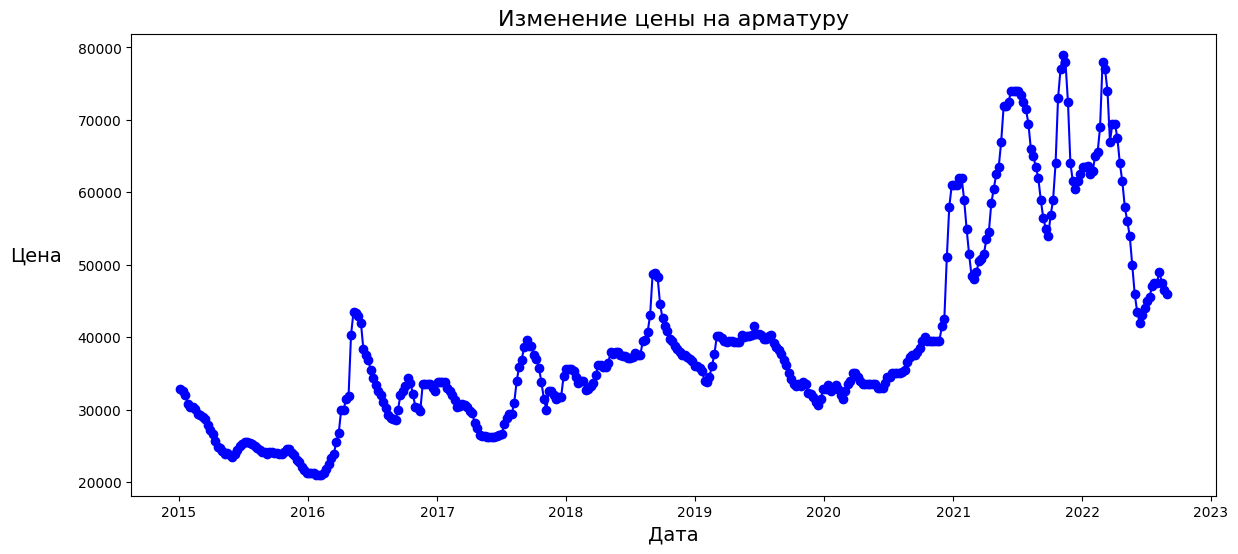

In [563]:
import matplotlib.pyplot as plt

# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
plt.title('Изменение цены на арматуру', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=14)
plt.plot(train_df.index, train_df['Цена на арматуру'], marker='o', linestyle='-', color='b')

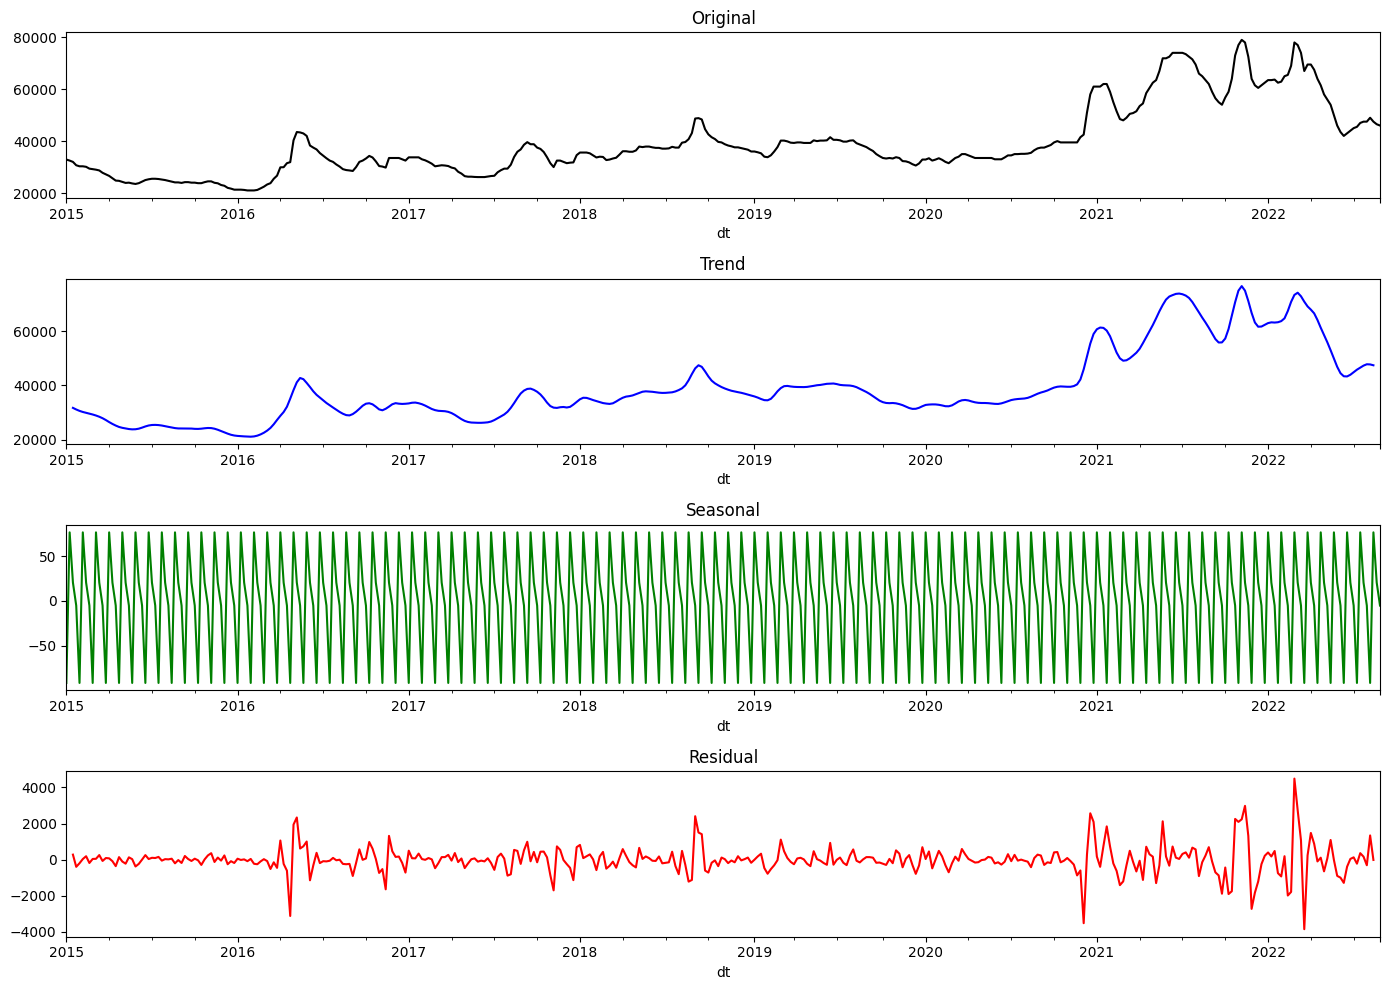

In [564]:
# Разложим ряд на компоненты и ответим: Есть ли у данного ряда тренд? Есть ли у данного ряда сезонность?

from statsmodels.tsa.seasonal import seasonal_decompose

# Выполняем декомпозицию
decomposition = seasonal_decompose(train_df["Цена на арматуру"], model="additive", period=4)

# Визуализация
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))
ax[0].set_title("Original")
ax[1].set_title("Trend")
ax[2].set_title("Seasonal")
ax[3].set_title("Residual")

decomposition.observed.plot(ax=ax[0], color="black")
decomposition.trend.plot(ax=ax[1], color="blue")
decomposition.seasonal.plot(ax=ax[2], color="green")
decomposition.resid.plot(ax=ax[3], color="red")

plt.tight_layout()
plt.show()

In [565]:
from statsmodels.tsa.stattools import adfuller
# Проверка стационарности
adf_test = adfuller(train_df["Цена на арматуру"])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

# Ряд является нестационарным

ADF Statistic: -1.9258699893713456, p-value: 0.31999061025699155


In [566]:
train_df['diff_1'] = train_df['Цена на арматуру'].diff()

# Проверка стационарности после первого дифференцирования
adf_test_diff1 = adfuller(train_df['diff_1'].dropna())

print("\nТест Дики-Фуллера после первого дифференцирования:")
print(f"ADF-статистика: {adf_test_diff1[0]}")
print(f"p-значение: {adf_test_diff1[1]}")
print(f"Критические значения: {adf_test_diff1[4]}")

if adf_test_diff1[1] < 0.05:
    print("Ряд стал стационарным после первого дифференцирования.")
else:
    print("Ряд все еще не стационарен, попробуем второе дифференцирование.")


Тест Дики-Фуллера после первого дифференцирования:
ADF-статистика: -7.706061504115209
p-значение: 1.300693837380985e-11
Критические значения: {'1%': np.float64(-3.447405233596701), '5%': np.float64(-2.8690569369014605), '10%': np.float64(-2.5707743450830893)}
Ряд стал стационарным после первого дифференцирования.


In [567]:
train_df = train_df.reset_index()

# Количество лагов (сколько предыдущих недель учитывать)
num_lags = 10

# Добавляем лаговые переменные
for lag in range(1, num_lags + 1):
    train_df[f'lag_{lag}'] = train_df['Цена на арматуру'].shift(lag)

# Добавляем скользящее среднее (по 4 и 8 неделям)
train_df['rolling_mean_4'] = train_df['Цена на арматуру'].rolling(window=4).mean()
train_df['rolling_mean_8'] = train_df['Цена на арматуру'].rolling(window=8).mean()

# Добавляем временные признаки
train_df['year'] = train_df['dt'].dt.year
train_df['month'] = train_df['dt'].dt.month
train_df['week'] = train_df['dt'].dt.isocalendar().week

# Убираем пропущенные значения (из-за лагов)
train_df = train_df.dropna()

# train_df.set_index('dt', inplace=True)

train_df.head()

,dt,Цена на арматуру,diff_1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_4,rolling_mean_8,year,month,week
10,2015-03-16,28700,-300.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0,32500.0,32900.0,29075.0,29712.5,2015,3,12
11,2015-03-23,27800,-900.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0,32500.0,28675.0,29350.0,2015,3,13
12,2015-03-30,27200,-600.0,27800.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0,28175.0,28962.5,2015,3,14
13,2015-04-06,26600,-600.0,27200.0,27800.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,27575.0,28500.0,2015,4,15
14,2015-04-13,25700,-900.0,26600.0,27200.0,27800.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,26825.0,27950.0,2015,4,16


автокорреляция

In [568]:
from statsmodels.tsa.stattools import acf

acf(train_df['Цена на арматуру'], nlags=60, fft=False)

array([1.        , 0.99079798, 0.97233848, 0.94905222, 0.92444165,
       0.89974335, 0.87647585, 0.85490144, 0.83577952, 0.81930063,
       0.80531981, 0.79314585, 0.78304673, 0.7750815 , 0.76991146,
       0.76658042, 0.76349805, 0.75884438, 0.75222873, 0.74326866,
       0.73275959, 0.72118899, 0.70883078, 0.69475369, 0.67929903,
       0.66290349, 0.64546404, 0.62726832, 0.60986996, 0.59306798,
       0.57692946, 0.56229872, 0.54893809, 0.53662049, 0.5252936 ,
       0.51472153, 0.50421298, 0.49412928, 0.48398669, 0.47317184,
       0.46102109, 0.4460853 , 0.42808952, 0.407851  , 0.38668584,
       0.36422163, 0.34101255, 0.31795254, 0.29548336, 0.27499703,
       0.25697699, 0.24122067, 0.22631872, 0.2129373 , 0.20153356,
       0.19184452, 0.18380406, 0.17644543, 0.16990556, 0.1639514 ,
       0.15948995])

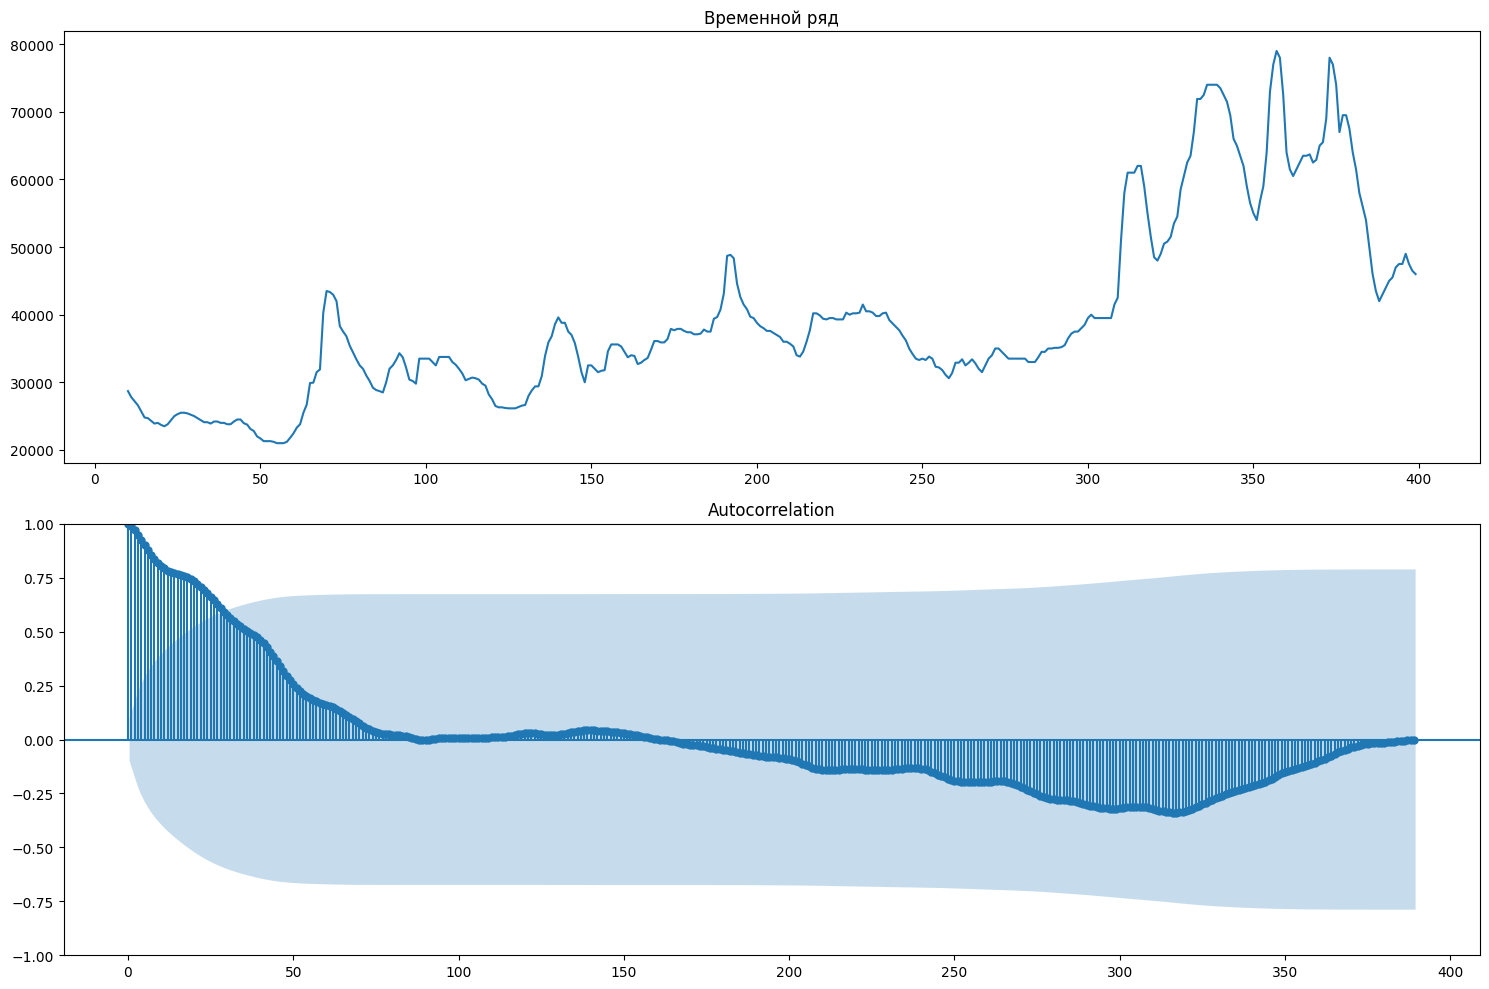

In [569]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# График временного ряда
train_df['Цена на арматуру'].plot(ax=ax[0], title="Временной ряд")

# График автокорреляции (с корректным числом лагов)
plot_acf(train_df['Цена на арматуру'], lags=len(train_df)-1, ax=ax[1])

plt.tight_layout()
plt.show()

Модели

In [570]:
test_df = pd.read_excel('test.xlsx')

In [571]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['dt', 'Цена на арматуру'])  # dt не нужен
y = train_df['Цена на арматуру']

train_size = int(len(X) * 0.85)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

Модель линейной регрессии

In [572]:
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

linreg_preds = linreg_model.predict(X_test)

In [573]:
# dates = train_df.index  # Или train_df['dt'], если это колонка с датами
# X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
#     X, y, dates, test_size=0.2, random_state=42
# )

# plt.scatter(dates_test, y_test, color='blue', label='Actual')
# plt.plot(dates_test, linreg_preds, color='red', label='Predicted')

# plt.xlabel('Date')
# plt.ylabel('Цена на арматуру')
# plt.title('Linear Regression')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()


In [574]:
from sklearn.metrics import r2_score, mean_absolute_error

rlinreg_mae = mean_absolute_error(y_test, linreg_preds)
linreg_r2 = r2_score(y_test, linreg_preds)

In [575]:
linreg_r2

1.0

In [576]:
rlinreg_mae

2.1346919712121203e-10

XGBRegressor

In [577]:

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer


# Создаем модель XGBoost
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 3233.96
RMSE: 3879.36
R²: 0.8577


In [578]:

# Предобработка тестовых данных (создание признаков)
test_df = test_df.sort_values('dt')
test_df['diff_1'] = test_df['Цена на арматуру'].diff()

# Лаги и скользящее среднее
for lag in range(1, num_lags + 1):
    test_df[f'lag_{lag}'] = test_df['Цена на арматуру'].shift(lag)

test_df['rolling_mean_4'] = test_df['Цена на арматуру'].rolling(window=4).mean()
test_df['rolling_mean_8'] = test_df['Цена на арматуру'].rolling(window=8).mean()
test_df['year'] = test_df['dt'].dt.year
test_df['month'] = test_df['dt'].dt.month
test_df['week'] = test_df['dt'].dt.isocalendar().week

# Убираем пропущенные значения
test_df = test_df.dropna()

In [579]:
# Прогноз на тестовых данных
X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])
y_pred = xgb_model.predict(X_test)

test_df['Forecast'] = y_pred

In [580]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train, y_train)


    y_pred = xgb_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"MAE for each fold: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")
print(f"Standard deviation of MAE: {np.std(mae_scores):.2f}")

print(f"Standard deviation of R²: {np.std(r2_scores):.4f}")

xgb_model.fit(X, y)

MAE for each fold: [4011.599609375, 2064.741943359375, 382.7188415527344, 4736.1376953125, 3606.87890625]
Mean MAE: 2960.42
Standard deviation of MAE: 1557.10
Standard deviation of R²: 0.9911


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

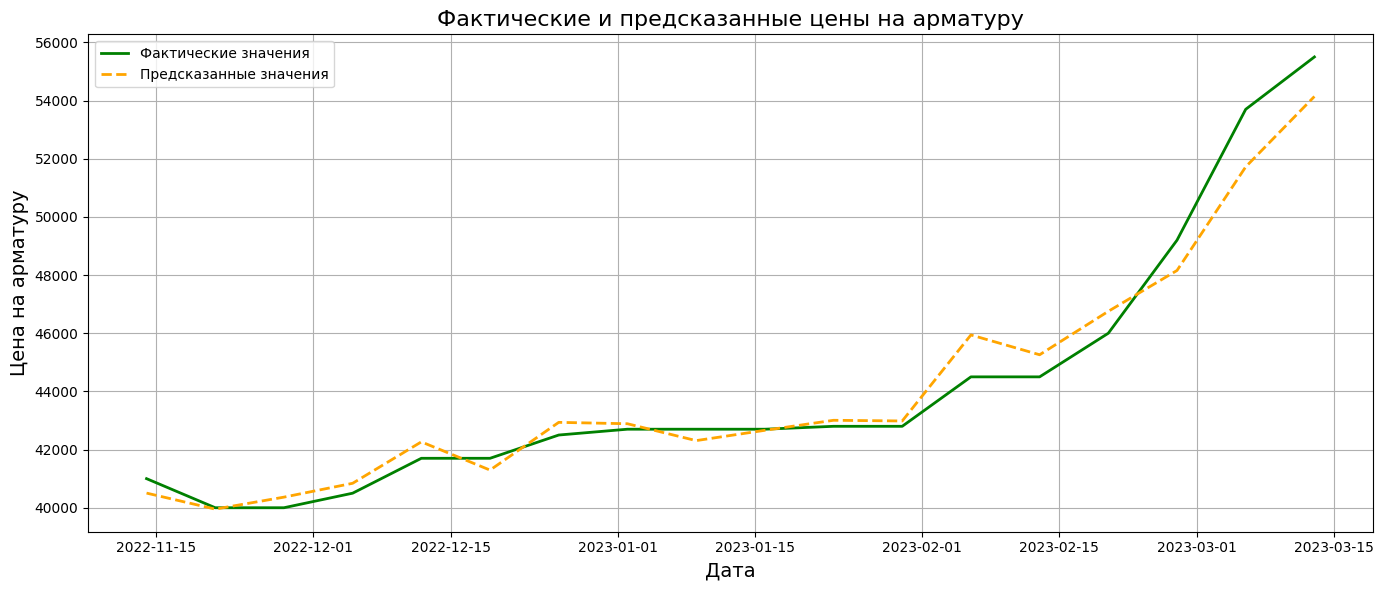

In [581]:
test_df = test_df.drop(columns=['Forecast'])

X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])  # Убираем ненужные колонки
y_pred = xgb_model.predict(X_test)  # Делаем прогноз

test_df['Forecast'] = y_pred

plt.figure(figsize=(14, 6))
plt.plot(test_df['dt'], test_df['Цена на арматуру'], label='Фактические значения', color='green', linewidth=2)
plt.plot(test_df['dt'], test_df['Forecast'], label='Предсказанные значения', color='orange', linestyle='--', linewidth=2)
plt.title('Фактические и предсказанные цены на арматуру', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена на арматуру', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Decision Tree

In [582]:
X = train_df.drop(columns=['dt', 'Цена на арматуру'])  # dt не нужен
y = train_df['Цена на арматуру']

train_size = int(len(X) * 0.85)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Создание модели DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 5799.88
RMSE: 6910.84
R²: 0.5485


In [583]:
# Предобработка тестовых данных
test_df = test_df.sort_values('dt')
test_df['diff_1'] = test_df['Цена на арматуру'].diff()

for lag in range(1, num_lags + 1):
    test_df[f'lag_{lag}'] = test_df['Цена на арматуру'].shift(lag)

test_df['rolling_mean_4'] = test_df['Цена на арматуру'].rolling(window=4).mean()
test_df['rolling_mean_8'] = test_df['Цена на арматуру'].rolling(window=8).mean()
test_df['year'] = test_df['dt'].dt.year
test_df['month'] = test_df['dt'].dt.month
test_df['week'] = test_df['dt'].dt.isocalendar().week

test_df = test_df.dropna()

In [584]:
min_len = min(len(test_df), len(y_pred))
test_df = test_df.iloc[:min_len].copy()
# Прогноз
X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])
# y_pred = dt_model.predict(X_test)
test_df['Forecast'] = y_pred[:min_len]

In [585]:

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"MAE for each fold: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")
print(f"Standard deviation of MAE: {np.std(mae_scores):.2f}")
print(f"Standard deviation of R²: {np.std(r2_scores):.4f}")

MAE for each fold: [4011.599609375, 2064.741943359375, 382.7188415527344, 4736.1376953125, 3606.87890625, 3336.373626373627, 2730.6666666666665, 796.4212454212455, 3946.396668561324, 4091.153846153846]
Mean MAE: 2970.31
Standard deviation of MAE: 1387.43
Standard deviation of R²: 0.8358


In [586]:
# Финальное обучение и прогноз
dt_model.fit(X, y)
test_df = test_df.drop(columns=['Forecast'])
X_test = test_df.drop(columns=['dt', 'Цена на арматуру'])
y_pred = dt_model.predict(X_test)
test_df['Forecast'] = y_pred

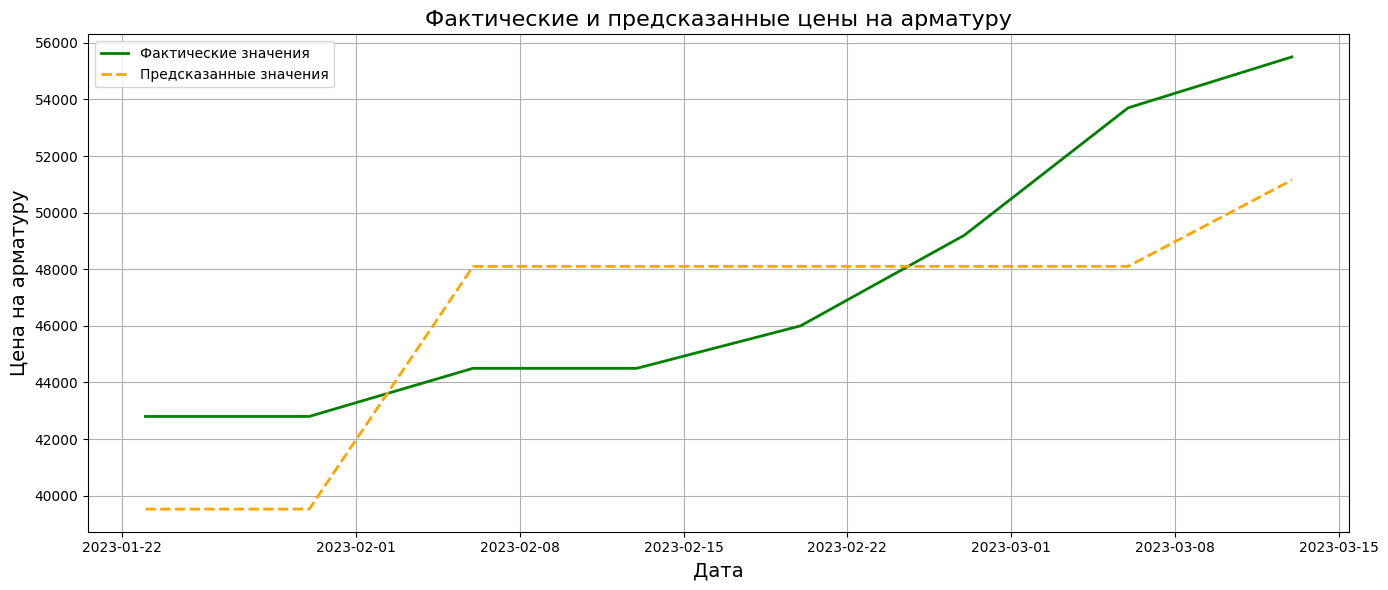

In [587]:
# График
plt.figure(figsize=(14, 6))
plt.plot(test_df['dt'], test_df['Цена на арматуру'], label='Фактические значения', color='green', linewidth=2)
plt.plot(test_df['dt'], test_df['Forecast'], label='Предсказанные значения', color='orange', linestyle='--', linewidth=2)
plt.title('Фактические и предсказанные цены на арматуру', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена на арматуру', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Выбор модели